In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import datetime as dt
import yfinance as yf
import pandas_ta
import xlsxwriter
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Get the SP500 tickers.
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace dots by dashes to avoid issues when using yfinace.
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-') 

# Get the list of tickers. 
symbols_list = sp500['Symbol'].unique().tolist()

# Get today's date.
end_date = dt.date.today()

# Get a n_years years ago date.
n_years = 8
start_date = pd.to_datetime(end_date) - pd.DateOffset(n_years * 365)

df = yf.download(tickers = symbols_list,
                start = start_date,
                end = end_date).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df.head()

[*********************100%%**********************]  503 of 503 completed


adj close      close       high        low       open  \
date       ticker                                                          
2015-11-02 A       36.128696  38.590000  38.619999  37.799999  37.869999   
           AAL     44.313290  46.470001  46.820000  46.200001  46.200001   
           AAPL    27.498983  30.295000  30.340000  29.902500  30.200001   
           ABBV    44.862259  63.380001  64.199997  61.439999  61.599998   
           ABT     39.108440  45.430000  45.500000  44.599998  44.880001   

                        volume  
date       ticker               
2015-11-02 A         1810800.0  
           AAL       6189300.0  
           AAPL    128813200.0  
           ABBV     17008700.0  
           ABT       5477800.0

# Features and indicators.

Next, we calculate the following features and technical indicators for the above stocks:
<ul>
  <li>Garman-Klass Volatility</li>
  <li>Relative Strength Index (RSI)</li>
  <li>Bollinger Bands</li>
  <li>Average True Range (ATR)</li>
  <li>Moving Average Convergence/Divergence  (MACD)</li>
  <li>Dollar Volume</li>
</ul>
    
    

## Garman-Klass Volatility
Let $T$ be the number of days in a sample, $o_t$ be the open price on day $t$, $c_t$ be the close price on day $t$, $l_t$ be the low price on day $t$ and $h_t$ be the high price on day $t$. Then *Garman-Klass Volatility* $\sigma_{GK}$ is given by
\begin{align}
    &\sigma_t
    =
    \frac{1}{2}
    \ln \left ( \frac{h_t}{l_t} \right )^2
    -
    (2\ln(2) - 1)
    \ln \left (\frac{c_t}{o_t} \right )^2
    ,
    &\sigma_{GK}
    =
    \left (
        \frac{1}{T}
        \sum_{t = 1}^{T}
        \sigma_t
     \right )^{\frac{1}{2}}
     .
\end{align}

In [3]:
df['garman_klass_volatility'] = np.log(df['high']/df['low'])**2 - (2 * np.log(2) - 1) * np.log(df['adj close']/df['open'])**2

## RSI

*Relative Strength Index* is a momentum indicator. It measures the the speed and magnitude of recent price mobements to evaluate whether the security is overvalued or undervalued. The RSI ranges from 0 to 100. The asset is considered overbought if the RSI is above 70 and underbought if it is below 30. The RSI is computed as
\begin{align}
    RSI(n) = 100 - \frac{100}{1 + RS(n)}
    ,
\end{align}
where $RS(n)$ is the *relative strength factor* given by a ratio of smoothed moving averages of upward and downward movements of the last $n$ days.

In [4]:
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))

## Bollinger Bands

*Bollinger Bands* are the set of trendlines defined by defined by a given number of standard deviations from the simple moving average of the security's price. The number of standard deviations is typically equal to two and the three Bollinger Bands are the simple moving average it self as the middle band, and +/- two standard deviations of it for the upper and lower bands, respectively. Bollinger Bands are used to identify whether the security is overbought (touches the upper Bollinger Band) or undervalued (touches the lower Bollinger Band).

In [5]:
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log(x)).iloc[:, 0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log(x)).iloc[:, 1])
df['bb_up'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log(x)).iloc[:, 2])


## ATR
*Average True Range* is a volatility indicator of an asset for a given period. It is computed using a simple moving average of the true range indicators, given by the maximum of the differences between current high and current low, current low and previous close, current high and previous close.

In [6]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                    low = stock_data['low'],
                    close = stock_data['close'],
                    length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

## MACD
*Moving average convergence/divergence* is a momentum indicator showing relationship between the exponential moving averages of the security's price over a 12-period and a 26-period.

In [7]:
def compute_macd(close):
    macd = pandas_ta.macd(close = close, length = 14)
    
    # Ensure MACD calculation results in a non-empty DataFrame.
    if macd is not None:
        macd = macd.iloc[:, 0]
        return macd.sub(macd.mean()).div(macd.std())
    else:
        return None

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd) 

df['dollar_volume'] = df['adj close'] * df['volume'] / 1e6

df.tail()

adj close       close        high         low        open  \
date       ticker                                                               
2023-10-27 XYL      88.169998   88.169998   89.250000   87.839996   88.690002   
           ZBH     103.190002  103.190002  104.809998  102.709999  104.000000   
           ZBRA    207.179993  207.179993  207.559998  201.160004  204.600006   
           ZION     29.450001   29.450001   30.670000   28.980000   30.590000   
           ZTS     156.029999  156.029999  157.929993  155.160004  157.929993   

                      volume  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                            
2023-10-27 XYL     1241700.0                 0.000240  37.991771  4.469428   
           ZBH     1534500.0                 0.000386  32.683065  4.627939   
           ZBRA     565000.0                 0.000920  36.064755  5.291795   
           ZION    2498300.0                 0.002655  37.602271  3.374234   
           ZTS     2407100.0                 0.000257  26.035790  5.033589   

                     bb_mid     bb_up       atr      macd  dollar_volume  
date       ticker                                                         
2023-10-27 XYL     4.485700  4.501973  0.124065 -1.085335     109.480687  
           ZBH     4.644261  4.660584 -0.290287 -1.382422     158.345059  
           ZBRA    5.320097  5.348398 -0.095011 -1.381441     117.056696  
           ZION    3.397390  3.420546  0.248610 -1.211125      73.574937  
           ZTS     5.088929  5.144269  0.565427 -2.411860     375.579810

# Aggregate to monthly level and filter most liquid stocks for each month.
Next, we convert data to month-end frequency.

In [8]:
last_cols = [col for col in df.columns.unique(0) if col not in ['dollar_volume', 'volume', 'high', 'low', 'open', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                  df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis = 1)).dropna()

def get_most_liquid(stock_data, n = 150):
    # Compute 5-year rolling average of 'dollar_volume' for each stock with at least 12 data points.
    stock_data['dollar_volume'] = stock_data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5 * 12, min_periods = 12).mean().stack()
    # Comppute ranking for each stock based on 'dollar_volume' for each month.
    stock_data['dollar_volume_rank'] = stock_data.groupby('date')['dollar_volume'].rank(ascending = False)
    # Filter stocks by their rank, leave n best.
    stock_data = stock_data[stock_data['dollar_volume_rank'] < n]
    return stock_data

# Get 150 most liquid stocks for each month and then drop 'dollar_volume' and 'dollar_volume_rank' columns.
data = get_most_liquid(data)
data = data.drop(['dollar_volume', 'dollar_volume_rank'], axis = 1)
data

adj close       atr    bb_low    bb_mid     bb_up  \
date       ticker                                                       
2016-11-30 AAL      44.876514  0.290894  3.797988  3.807300  3.816613   
           AAPL     25.747696 -1.033837  3.247647  3.255496  3.263345   
           ABBV     44.699749 -0.613497  3.771899  3.795086  3.818274   
           ABT      33.597473 -0.999700  3.512591  3.531748  3.550905   
           ACN     107.214012 -0.951963  4.672418  4.682389  4.692359   
...                       ...       ...       ...       ...       ...   
2023-10-31 VRTX    355.279999  0.540248  5.867677  5.895211  5.922746   
           VZ       33.439999  0.070140  3.442666  3.509736  3.576805   
           WFC      38.759998 -0.501673  3.653501  3.669664  3.685827   
           WMT     161.169998  0.265586  5.076690  5.087532  5.098375   
           XOM     105.550003  1.332516  4.656665  4.681278  4.705890   

                   garman_klass_volatility      macd        rsi  
date       ticker                                                
2016-11-30 AAL                    0.000676  2.379552  71.397629  
           AAPL                  -0.002189 -0.302304  48.015340  
           ABBV                  -0.039459 -0.243056  49.727629  
           ABT                   -0.007551 -0.536195  39.665384  
           ACN                   -0.005458  0.043727  54.807715  
...                                    ...       ...        ...  
2023-10-31 VRTX                   0.000485  0.470020  47.861952  
           VZ                     0.001058  0.706513  55.878738  
           WFC                    0.000313 -0.555938  39.325800  
           WMT                    0.000076 -0.079564  51.423163  
           XOM                    0.001707 -1.337935  40.190364  

[12516 rows x 8 columns]

# Monthly returns for different time-horizons as features.

In [9]:
def calculate_returns(df, lags = [1, 2, 3, 6, 9, 12], outlier_cutoff = 5e-3):
    # Iterate over specified lags.
    for lag in lags:
        # Compute percentage change over the lag period, add to the dataframe.
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper = x.quantile(1 - outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()
data

adj close       atr    bb_low    bb_mid     bb_up  \
date       ticker                                                       
2017-11-30 AAL      49.210892  0.380949  3.840252  3.869879  3.899507   
           AAPL     40.679478 -0.904130  3.688316  3.710550  3.732783   
           ABBV     73.854988 -0.374899  4.273912  4.288989  4.304067   
           ABT      50.901718 -1.059511  3.914863  3.924193  3.933523   
           ACN     135.549423 -0.929829  4.901340  4.906735  4.912130   
...                       ...       ...       ...       ...       ...   
2023-10-31 VRTX    355.279999  0.540248  5.867677  5.895211  5.922746   
           VZ       33.439999  0.070140  3.442666  3.509736  3.576805   
           WFC      38.759998 -0.501673  3.653501  3.669664  3.685827   
           WMT     161.169998  0.265586  5.076690  5.087532  5.098375   
           XOM     105.550003  1.332516  4.656665  4.681278  4.705890   

                   garman_klass_volatility      macd        rsi  return_1m  \
date       ticker                                                            
2017-11-30 AAL                    0.001252  0.446498  60.587929   0.080746   
           AAPL                  -0.000356  0.026230  57.636996   0.020278   
           ABBV                  -0.027144  0.341442  64.404147   0.073906   
           ABT                   -0.002674  0.142408  60.065439   0.039462   
           ACN                   -0.002392  0.308036  66.222739   0.039688   
...                                    ...       ...        ...        ...   
2023-10-31 VRTX                   0.000485  0.470020  47.861952   0.021683   
           VZ                     0.001058  0.706513  55.878738   0.053804   
           WFC                    0.000313 -0.555938  39.325800  -0.051395   
           WMT                    0.000076 -0.079564  51.423163   0.007753   
           XOM                    0.001707 -1.337935  40.190364  -0.102313   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-11-30 AAL      0.032230   0.041885   0.007744   0.010241    0.007713  
           AAPL     0.057851   0.016923   0.021096   0.026836    0.038851  
           ABBV     0.048005   0.090300   0.068909   0.054211    0.042732  
           ABT      0.030329   0.036023   0.037540   0.027025    0.035227  
           ACN      0.051863   0.045524   0.030945   0.023509    0.019735  
...                      ...        ...        ...        ...         ...  
2023-10-31 VRTX     0.009912   0.002774   0.006994   0.010605    0.010884  
           VZ      -0.011881   0.000721  -0.018261  -0.017877   -0.003348  
           WFC     -0.031121  -0.054125  -0.001605  -0.018499   -0.011819  
           WMT     -0.004438   0.003911   0.012194   0.013984    0.011693  
           XOM     -0.025692  -0.002570  -0.016131  -0.007750   -0.001344  

[10342 rows x 14 columns]

# Fama-French Factors and Rolling Factor Betas.
Next, we fetch the Fama-French factors, namely Market Excess Return, Small Minus Big, High Minus Low, Robust Minus Weak and Conservative Minus Aggressive, which are used to explain stock returns. We then use them with rolling window ordianry least squares to calculate beta, i.e. sensitivity of returns to the Fama-French factors.

In [10]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench',
              start = '2010')[0].drop('RF', axis = 1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.columns = factor_data.columns.str.lower()
factors = factor_data.columns
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

mkt-rf     smb     hml     rmw     cma  return_1m
date       ticker                                                   
2017-11-30 AAL     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.080746
           AAPL    0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.020278
           ABBV    0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.073906
           ABT     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039462
           ACN     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039688
...                   ...     ...     ...     ...     ...        ...
2023-07-31 VZ      0.0321  0.0286  0.0413 -0.0056  0.0062  -0.067220
           WFC     0.0321  0.0286  0.0413 -0.0056  0.0062   0.081537
           WMT     0.0321  0.0286  0.0413 -0.0056  0.0062   0.017051
           WYNN    0.0321  0.0286  0.0413 -0.0056  0.0062   0.031910
           XOM     0.0321  0.0286  0.0413 -0.0056  0.0062  -0.000093

[9906 rows x 6 columns]

In [11]:
observations = factor_data.groupby(level = 1).size()
valid_stocks = observations[observations >= 10] # select stocks with at least 10 months of data. 
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [12]:
betas = (factor_data.groupby(level = 1, 
                    group_keys = False).apply(lambda x: RollingOLS(endog = x['return_1m'],
                                                                   exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                                                   window = min(24, x.shape[0]),
                                                                   min_nobs = len(x.columns) + 1)
                                              .fit(params_only = True)
                                              .params
                                              .drop('const', axis = 1)))

data = (data.join(betas.groupby('ticker', level = 1).shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10058 entries, (Timestamp('2017-11-30 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-10-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   atr                      10058 non-null  float64
 1   bb_low                   10058 non-null  float64
 2   bb_mid                   10058 non-null  float64
 3   bb_up                    10058 non-null  float64
 4   garman_klass_volatility  10058 non-null  float64
 5   macd                     10058 non-null  float64
 6   rsi                      10058 non-null  float64
 7   return_1m                10058 non-null  float64
 8   return_2m                10058 non-null  float64
 9   return_3m                10058 non-null  float64
 10  return_6m                10058 non-null  float64
 11  return_9m                10058 non-null  float64
 12  return_12m               10058 non

# K-Means Clustering for similar stocks.
We use K-Means Clustering Algorithm to group stocks based on their features. We select initial centroids based on the RSI momentum indicator.

In [13]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4,
                           random_state = 42,
                           init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr    bb_low    bb_mid     bb_up  \
date       ticker                                           
2017-11-30 AAL     0.380949  3.840252  3.869879  3.899507   
           AAPL   -0.904130  3.688316  3.710550  3.732783   
           ABBV   -0.374899  4.273912  4.288989  4.304067   
           ABT    -1.059511  3.914863  3.924193  3.933523   
           ACN    -0.929829  4.901340  4.906735  4.912130   
...                     ...       ...       ...       ...   
2023-10-31 VRTX    0.540248  5.867677  5.895211  5.922746   
           VZ      0.070140  3.442666  3.509736  3.576805   
           WFC    -0.501673  3.653501  3.669664  3.685827   
           WMT     0.265586  5.076690  5.087532  5.098375   
           XOM     1.332516  4.656665  4.681278  4.705890   

                   garman_klass_volatility      macd        rsi  return_1m  \
date       ticker                                                            
2017-11-30 AAL                    0.001252  0.446498  60.587929   0.080746   
           AAPL                  -0.000356  0.026230  57.636996   0.020278   
           ABBV                  -0.027144  0.341442  64.404147   0.073906   
           ABT                   -0.002674  0.142408  60.065439   0.039462   
           ACN                   -0.002392  0.308036  66.222739   0.039688   
...                                    ...       ...        ...        ...   
2023-10-31 VRTX                   0.000485  0.470020  47.861952   0.021683   
           VZ                     0.001058  0.706513  55.878738   0.053804   
           WFC                    0.000313 -0.555938  39.325800  -0.051395   
           WMT                    0.000076 -0.079564  51.423163   0.007753   
           XOM                    0.001707 -1.337935  40.190364  -0.102313   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-11-30 AAL      0.032230   0.041885   0.007744   0.010241    0.007713   
           AAPL     0.057851   0.016923   0.021096   0.026836    0.038851   
           ABBV     0.048005   0.090300   0.068909   0.054211    0.042732   
           ABT      0.030329   0.036023   0.037540   0.027025    0.035227   
           ACN      0.051863   0.045524   0.030945   0.023509    0.019735   
...                      ...        ...        ...        ...         ...   
2023-10-31 VRTX     0.009912   0.002774   0.006994   0.010605    0.010884   
           VZ      -0.011881   0.000721  -0.018261  -0.017877   -0.003348   
           WFC     -0.031121  -0.054125  -0.001605  -0.018499   -0.011819   
           WMT     -0.004438   0.003911   0.012194   0.013984    0.011693   
           XOM     -0.025692  -0.002570  -0.016131  -0.007750   -0.001344   

                     mkt-rf       smb       hml       rmw       cma  cluster  
date       ticker                                                             
2017-11-30 AAL     1.252259  1.322740  0.628244  0.478386  0.583445        2  
           AAPL    1.293096 -0.288444 -0.626194  0.650797  0.536791        2  
           ABBV    0.489783  0.414045 -0.030089  0.261810  0.136695        2  
           ABT     0.830006 -0.208142 -0.537611  0.243535  0.990227        2  
           ACN     1.202939 -0.153611 -0.324493  0.266949  0.189729        2  
...                     ...       ...       ...       ...       ...      ...  
2023-10-31 VRTX    0.531046  0.089365 -0.979734  0.098838  0.856468        1  
           VZ      0.513887 -0.366528  0.027699  0.305851  0.587426        2  
           WFC     1.088212 -0.135259  1.329530 -0.755140 -0.442986        3  
           WMT     0.611424 -0.467783 -0.298395  0.388982  0.737115        2  
           XOM     1.163855  0.389047  0.532604 -0.468492  0.786427        3  

[10058 rows x 19 columns]

# For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max Sharpe ratio optimization.
We select stocks from the highest RSI momentum indicator cluster for each month. The hypothesis is that that the momentum persists. We use EfficientFrontier optimizer from PyPortfolioOpt package to find the optimal portfolio weights. To ensure the resulting portfolio is diversified, we use weight bounds to ensure that the weights are at least half the uniform portfolio weights and at most 10% of the portfolio.

In [14]:
filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level = 1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()
fixed_dates

{'2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFL

In [15]:
def optimize_weights(prices, lower_bound = 0):
    
    returns = expected_returns.mean_historical_return(prices = prices, frequency = 252)
    
    cov = risk_models.sample_cov(prices = prices, frequency = 252)
    
    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound, .1),
                           solver = 'SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                     start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-11-30  44.876518   25.747690   44.699749  33.597469  107.214020   
2016-12-01  44.209743   25.507732   43.494034  33.182693  105.625076   
2016-12-02  44.547958   25.603251   43.692535  33.447449  105.292900   
2016-12-05  44.180756   25.419210   44.743858  33.915184  105.678932   
2016-12-06  44.866852   25.614901   45.302605  33.906361  106.298347   
...               ...         ...         ...        ...         ...   
2023-10-24  11.210000  173.440002  146.309998  94.809998  296.089996   
2023-10-25  11.040000  171.100006  145.259995  93.570000  292.679993   
2023-10-26  11.150000  166.889999  145.199997  93.980003  292.040009   
2023-10-27  10.920000  168.220001  138.929993  92.849998  290.040009   
2023-10-30  11.075000  170.824997  144.089996  92.239998  291.339996   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-11-30  102.809998   82.871902   72.610001  52.607319   29.722990  ...   
2016-12-01   99.510002   82.656143   69.220001  53.255264   27.784534  ...   
2016-12-02   99.730003   82.198708   70.570000  52.956215   29.021452  ...   
2016-12-05  101.949997   82.897797   71.180000  53.346638   29.104532  ...   
2016-12-06  101.550003   82.854652   76.320000  53.597088   29.178379  ...   
...                ...         ...         ...        ...         ...  ...   
2023-10-24  539.559998  240.449997  205.039993  59.869999  134.899994  ...   
2023-10-25  521.140015  218.330002  200.210007  60.959999  130.110001  ...   
2023-10-26  514.280029  218.839996  196.119995  60.849998  130.839996  ...   
2023-10-27  508.119995  214.839996  195.149994  59.529999  131.300003  ...   
2023-10-30  521.510010  214.925003  195.229996  60.599998  132.744995  ...   

              Volume                                                   \
                   V       VLO     VRTX        VZ       WBA       WDC   
Date                                                                    
2016-11-30  15353900  14238400  2292700  20698900   5951900   5383000   
2016-12-01  21053000  10720500  2662600  12982800   4463500   5508400   
2016-12-02  13629600   5295700  4580500  10650700   3928600   3496900   
2016-12-05  12119200   8277900  2588600  13074700   2800200   6865600   
2016-12-06  13896600   5149300  1816700  13581500   2911400   5049500   
...              ...       ...      ...       ...       ...       ...   
2023-10-24   6844100   2913400   997300  61617900  10157700   4314300   
2023-10-25  10365300   3056200   958000  30832800  10408400   2764400   
2023-10-26   6414500   3992500   942100  34367000   8832500  17872200   
2023-10-27   5540100   3674500   910700  23917700   9201900   6532800   
2023-10-30    404429    183974    98111   4043945    649332   4373355   

                                                   
                 WFC       WMT     WYNN       XOM  
Date                                               
2016-11-30  26567200   9326100  2618300  22696200  
2016-12-01  35623100   6849800  3881900  13005600  
2016-12-02  21894700   6674200  1955500   9706600  
2016-12-05  24793900  10527900  1678600  11741100  
2016-12-06  30706700   7778000  2892100  11293600  
...              ...       ...      ...       ...  
2023-10-24  15097800   5845000  1335000  16786100  
2023-10-25  13849000   5540600  1518500  22047300  
2023-10-26  15480300   5406700  2183400  18768300  
2023-10-27  13582500   4609900  1587200  23082800  
2023-10-30    660548    427331    76285   1786256  

[1740 rows x 918 columns]

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months  = 12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days = 1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        # Attempt to calculate optimal Sharpe weights, else use uniform weights.
        success = False
        try:
            weights = optimize_weights(prices = optimization_df,
                                   lower_bound = round(1 / (len(optimization_df.columns) * 2), 3))

            weights = pd.DataFrame(weights, index = pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal Weights')
        
        if success == False:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index = optimization_df.columns.tolist(),
                                     columns = pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level = 0, drop = True),
                          left_index = True,
                          right_index = True).reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level = 0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal Weights
'return'


,Strategy Return
date,
2017-12-01,-0.007031
2017-12-04,0.001250
2017-12-05,-0.003742
2017-12-06,-0.000562
2017-12-07,0.005869
...,...
2023-10-24,0.014945
2023-10-25,-0.022840
2023-10-26,-0.019692


# Compare performance to S&P 500 returns.

[*********************100%%**********************]  1 of 1 completed


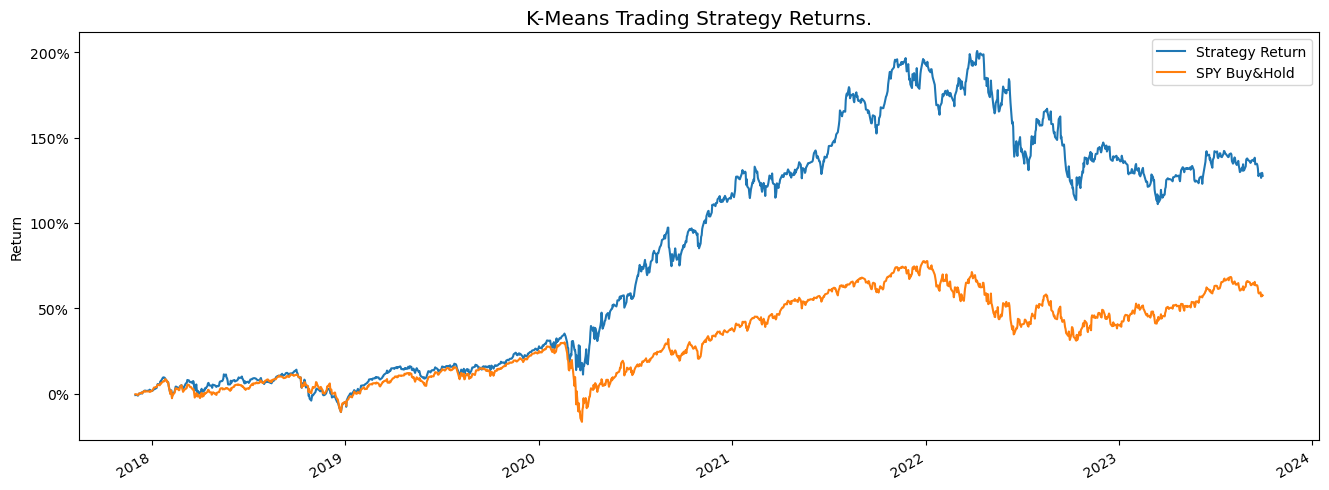

In [18]:
spy = yf.download(tickers = 'SPY',
                  start = '2015-01-01',
                  end = dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis = 1)
portfolio_df = portfolio_df.merge(spy_ret, left_index = True, right_index = True)
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumulative_return[:'2023-10-01'].plot(figsize = (16,6))

plt.style.use('ggplot')
plt.title('K-Means Trading Strategy Returns.')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

# Save the order as an Excel file.

In [19]:
# Get the size of the portfolio.
def portfolio_input():
    global portfolio_size
    portfolio_size = input('Enter the size of your portfolio: ')
    
    try:
        float(portfolio_size)
    except:
        print('That is not a number\nPlease try again: ')
        portfolio_size = input('Enter the size of your portfolio: ')
    
    portfolio_size = float(portfolio_size)
    
portfolio_input()

Enter the size of your portfolio: 1000000


In [20]:
# Compute the number of shares to buy.
order_df = pd.DataFrame()
order_df.index = weights.columns.rename('Ticker')
order_df['Ticker'] = weights.columns.rename('Ticker')
order_df['Latest Price'] = new_df.tail(1)['Adj Close'][order_df.index].T
order_df['Number of Shares to Buy'] = (weights.T[0] * portfolio_size).apply(lambda x: int(x))
order_df = order_df.reset_index(drop = True)
order_df

,Ticker,Latest Price,Number of Shares to Buy
0,AAPL,170.824997,11000
1,ABBV,144.089996,11000
2,ABT,92.239998,11000
3,ACN,291.339996,11000
4,ADSK,195.229996,11000
5,AMAT,132.744995,100000
6,AXP,142.889999,11000
7,BA,181.009995,43400
8,BAC,25.545000,11000
9,BDX,249.554993,11000


In [21]:
with pd.ExcelWriter('k_means_strategy.xlsx', engine = 'xlsxwriter') as writer:
    order_df.to_excel(writer, sheet_name = 'K-Means Strategy', index = False)

    background_color = '#0a0a23'
    font_color = '#ffffff'

    string_template = writer.book.add_format(
            {
                'font_color': font_color,
                'bg_color': background_color,
                'border': 1
            }
        )

    dollar_template = writer.book.add_format(
            {
                'num_format': '$0.00',
                'font_color': font_color,
                'bg_color': background_color,
                'border': 1
            }
        )

    integer_template = writer.book.add_format(
            {
                'num_format': '0',
                'font_color': font_color,
                'bg_color': background_color,
                'border': 1
            }
        )

    column_formats = {
        'A': ['Ticker', string_template],
        'B': ['Latest Price', dollar_template],
        'C': ['Number of Shares to Buy', integer_template],
    }

    for column in column_formats.keys():
        writer.sheets['K-Means Strategy'].set_column(f'{column}:{column}', 18, column_formats[column][1])
        writer.sheets['K-Means Strategy'].write(f'{column}1', column_formats[column][0], string_template)